In [1]:
import os
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import glob
import cv2
import csv
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import transforms as T
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [2]:
DATASET = 'data'
TESTING = 'test_imgs'

files = glob.glob('data/**/*.txt', recursive = True) #find all *.txt files

target_txt = "dataset_not_orig.txt"
test_txt = "test_set.txt"

In [4]:
#TRAINING DATASET

In [3]:
train_df = pd.read_csv(target_txt, sep=',', header=None, names=['img_path', 'x0', 'y0', 'x1', 'y1', 'label'])
train_df.head()

,img_path,x0,y0,x1,y1,label
0,19-12-09_1652_624622812/000_03_04.png,463.0,204.0,560.0,241.0,2
1,19-12-09_1652_624622812/000_03_04.png,64.0,470.0,210.0,540.0,2
2,19-12-09_1652_624622812/000_03_04.png,267.0,464.0,332.0,535.0,1
3,19-12-09_1652_624622812/000_03_04.png,577.0,184.0,610.0,294.0,1
4,19-12-09_1652_624622812/000_03_04.png,346.0,268.0,421.0,366.0,1


In [4]:
train_df['img_path'].nunique()

771

In [5]:
train_df['label'].value_counts()

1    3568
2    1062
Name: label, dtype: int64

In [8]:
#TESTING DATASET

In [6]:
test_df = pd.read_csv(test_txt, sep=',', header=None, names=['img_path', 'x0', 'y0', 'x1', 'y1', 'label'])
test_df.head()

,img_path,x0,y0,x1,y1,label
0,split4_033.png,165,303,493,402,1
1,split4_039.png,157,337,470,425,1
2,split4_057.png,247,404,626,472,1
3,split4_040.png,159,322,477,424,1
4,split4_041.png,164,343,477,421,1


In [7]:
test_df['img_path'].nunique()

158

In [8]:
test_df['label'].value_counts()

1    119
2     42
Name: label, dtype: int64

# TRAINING

In [9]:
#train shape
train_df.shape

#number of unique images
print(f"Unique images are {train_df['img_path'].nunique()}")

#number of images in dir
folder_images = []
for f in files:
  if "mask" not in f:
    folder_images.append(f)
print(f"Images in folder are {len(folder_images)}")

Unique images are 771
Images in folder are 12148


In [10]:
images_ids = train_df['img_path'].unique()

split_len = round(len(images_ids)*0.8) #80% -> train & 20% -> val

train_ids = images_ids[:split_len]
valid_ids = images_ids[split_len:]

train = train_df[train_df['img_path'].isin(train_ids)]
valid = train_df[train_df['img_path'].isin(train_ids)]

print(f"Train shape is {train.shape} and Validation shape is {valid.shape}")

Train shape is (3727, 6) and Validation shape is (3727, 6)


In [11]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
  figsize = (num_cols * scale, num_rows * scale)
  _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles and len(titles) > i:
      ax.set_title(titles[i])
  return axes

def show_bboxes(axes, bboxes, labels=None, colors=None):
  def _make_list(obj, default_values=None):
    if obj is None:
      obj = default_values
    elif not isinstance(obj, (list, tuple)):
      obj = [obj]
    return obj

  labels = _make_list(labels)
  colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
  for i, bbox in enumerate(bboxes):
    color = colors[i % len(colors)]
    rect = plt.Rectangle(
      xy=(bbox[0], bbox[1]),
      width=bbox[2] - bbox[0],
      height=bbox[3] - bbox[1],
      fill=False,
      edgecolor=color,
      linewidth=2)
    axes.add_patch(rect)
    if labels and len(labels) > i:
      text_color = 'k' if color == 'w' else 'w'
      axes.text(rect.xy[0], rect.xy[1], labels[i], va='center',
                ha='center', fontsize=9, color=text_color,
                bbox=dict(facecolor=color, lw=0))

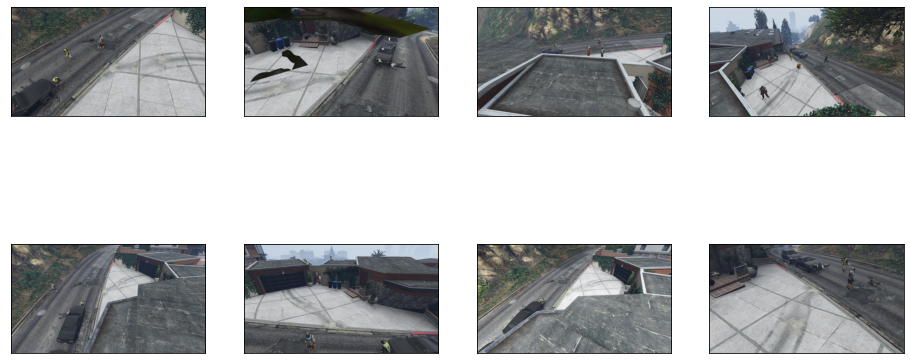

In [12]:
num_rows, num_cols = 2, 4
imgs = [plt.imread(f'{DATASET}/{n}') for n in train_df['img_path'].unique()[:num_rows*num_cols]]
show_images(imgs, num_rows, num_cols, scale=4)
plt.show()

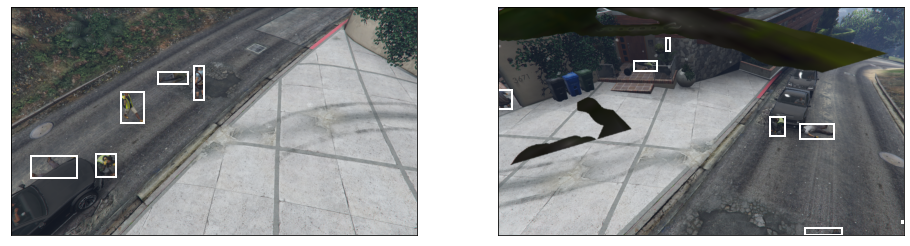

In [13]:
num_rows, num_cols = 1, 2
ids = train_df['img_path'].unique()[:num_rows*num_cols]
imgs = [plt.imread(f'{DATASET}/{n}') for n in ids]
axes = show_images(imgs, num_rows, num_cols, scale=8)
for ax, id in zip(axes, ids):
  datas = train_df[train_df['img_path'] == id]
  bboxes = [(d['x0'], d['y0'], d['x1'], d['y1']) for _, d in datas.iterrows()]
  show_bboxes(ax, bboxes, labels=None, colors=['w'])
plt.show()

In [ ]:
#SHOW TESTING IMGS

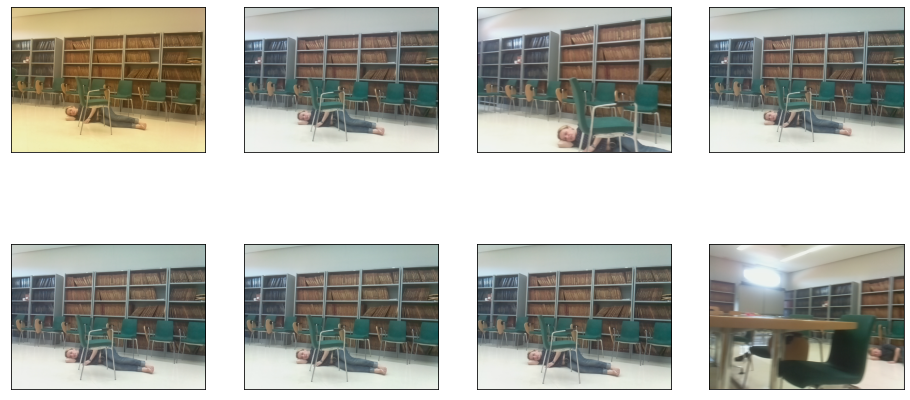

In [14]:
num_rows, num_cols = 2, 4
imgs = [plt.imread(f'{TESTING}/{n}') for n in test_df['img_path'].unique()[:num_rows*num_cols]]
show_images(imgs, num_rows, num_cols, scale=4)
plt.show()

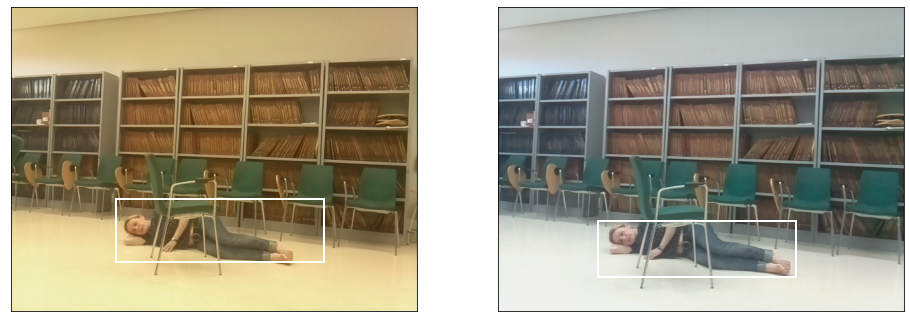

In [15]:
num_rows, num_cols = 1, 2
ids = test_df['img_path'].unique()[:num_rows*num_cols]
imgs = [plt.imread(f'{TESTING}/{n}') for n in ids]
axes = show_images(imgs, num_rows, num_cols, scale=8)
for ax, id in zip(axes, ids):
  datas = test_df[test_df['img_path'] == id]
  bboxes = [(d['x0'], d['y0'], d['x1'], d['y1']) for _, d in datas.iterrows()]
  show_bboxes(ax, bboxes, labels=None, colors=['w'])
plt.show()

In [16]:
class FallenPeople(Dataset):

    def __init__(self, dataframe, img_dir, transforms):
        super().__init__()
        self.image_ids = dataframe['img_path'].unique()
        self.df = dataframe
        self.img_dir = img_dir
        self.transforms = transforms

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        records = self.df[self.df['img_path'] == image_id]

        image = cv2.imread(f'{self.img_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x0', 'y0', 'x1', 'y1']].values
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = records['label'].values
        labels = torch.as_tensor(labels, dtype = torch.int64)
        image_id = torch.tensor([idx])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.uint8)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target["image_id"] = image_id
        target['img_path'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowd'] = iscrowd

    #     if self.transforms is not None:
    #         sample = {'image': image, 'bboxes': target['boxes'], 'labels': labels}
    #         sample = self.transforms(**sample)
    #         image = sample['image']
    #         target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        if self.transforms is not None:
            image, target = self.transforms(image, target)


        return image, target

    def __len__(self) -> int:
        return len(self.image_ids)

In [17]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [18]:
train_dataset = FallenPeople(train, DATASET, get_transform(train=True))
valid_dataset = FallenPeople(valid, DATASET, get_transform(train=False))
test_dataset = FallenPeople(test_df, TESTING, get_transform(train=False))

In [19]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
53.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

71.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

90.5%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the c

In [20]:
print(model.roi_heads.box_predictor)

num_classes = 3 # fall or no fall or not(background)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained model's head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

print(model.roi_heads.box_predictor)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=91, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
)
FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=3, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=12, bias=True)
)


In [21]:
def collate_fn(batch):
  return tuple(zip(*batch))

train_data_loader = DataLoader(
  train_dataset,
  batch_size=4,
  shuffle=False,
  collate_fn=collate_fn
)

valid_data_loader = DataLoader(
  valid_dataset,
  batch_size=4,
  shuffle=False,
  collate_fn=collate_fn
)

test_data_loader = DataLoader(
  test_dataset,
  batch_size=4,
  shuffle=False,
  collate_fn=collate_fn
)

In [22]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# move model to the right device
model.to(device)

# create an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# create a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

# train it for 10 epochs
num_epochs = 10

In [31]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    boxA = boxA.tolist()
    boxB = boxB.tolist()
    l = len(boxB)
    iou_tot = []
    for i in range(l): 
        xA = max(boxA[i][0], boxB[i][0])
        yA = max(boxA[i][1], boxB[i][1])
        xB = min(boxA[i][2], boxB[i][2])
        yB = min(boxA[i][3], boxB[i][3])
        # compute the area of intersection rectangle
        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
        # compute the area of both the prediction and ground-truth
        # rectangles
        boxAArea = (boxA[i][2] - boxA[i][0] + 1) * (boxA[i][3] - boxA[i][1] + 1)
        boxBArea = (boxB[i][2] - boxB[i][0] + 1) * (boxB[i][3] - boxB[i][1] + 1)
        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = interArea / float(boxAArea + boxBArea - interArea)
        iou_tot.append(iou)
    # return the intersection over union value
    return iou

In [41]:
# def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
#     # You can comment out this line if you are passing tensors of equal shape
#     # But if you are passing output from UNet or something it will most probably
#     # be with the BATCH x 1 x H x W shape
#     outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
#     intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
#     union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
#     iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
#     thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
#     return thresholded

In [23]:
!pip install tqdm

     |################################| 76 kB 390 kB/s             


In [24]:
log_txt = "trainlogs/train_log.txt"

In [25]:
%%bash

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-k93gr1ah
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266215 sha256=ab98d1b345c459b5fd0e979f82c959ddf123637e17748c6267f3cd0d9faa9e0b
  Stored in directory: /tmp/pip-ephem-wheel-cache-m_51gxd8/wheels/25/c1/63/8bee2969883497d2785c9bdbe4e89cae5efc59521553d528bf
Successfully built pycocotools


  Running command git clone --filter=blob:none -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-k93gr1ah


In [26]:
from engine import evaluate
import sys

original_stdout = sys.stdout

In [31]:
from tqdm.notebook import tqdm as tqdm
#training funzionante
itr = 1

total_train_loss = []
total_valid_loss = []

losses_value = 0.0

f_log = open(log_txt, "w")
for epoch in range(num_epochs):

  start_time = time.time()

  # train ------------------------------
  running_corrects = 0

  model.train()
  train_loss = []
  pbar = tqdm(train_data_loader, desc='let\'s train')
    
  for images, targets in pbar:    

    images = list(image.to(device) for image in images)

    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    losses_value = losses.item()
    train_loss.append(losses_value)   

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    
    f_log.write(f"Epoch: {epoch+1}, Batch: {itr}, Loss: {losses_value}\n")
    pbar.set_description(f"Epoch: {epoch+1}, Batch: {itr}, Loss: {losses_value}")
    itr += 1
    
  epoch_train_loss = np.mean(train_loss)
  total_train_loss.append(epoch_train_loss)

  # update the learning rate
  if lr_scheduler is not None:
    lr_scheduler.step()

  # valid -------------------------------------

  with torch.no_grad():
    valid_loss = []
    
    for images, targets in valid_data_loader:
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
      loss_dict = model(images, targets)
      losses = sum(loss for loss in loss_dict.values())
      loss_value = losses.item()
      valid_loss.append(loss_value)
    
  epoch_valid_loss = np.mean(valid_loss)
  total_valid_loss.append(epoch_valid_loss)  

  # print ------------------------------
  f_log.write(f"Epoch Completed: {epoch+1}/{num_epochs}, Time: {time.time()-start_time}, "
        f"Train Loss: {epoch_train_loss}, Valid Loss: {epoch_valid_loss}\n")
  f_log.write("\nTESTING PHASE: ")

  print(f"Epoch Completed: {epoch+1}/{num_epochs}, Time: {time.time()-start_time}, "
        f"Train Loss: {epoch_train_loss}, Valid Loss: {epoch_valid_loss}")
  print("\nTESTING PHASE: ")

  sys.stdout = f_log
  #testing --------------------------------------
  evaluate(model, test_data_loader, device=device)
  sys.stdout = original_stdout
#   with torch.no_grad():
#     valid_loss = []
#     model.eval()
    
#     for images, targets, image_ids in test_data_loader:
#       images = list(image.to(device) for image in images)
#       targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#       labels = targets[0]['boxes']
#       prediction = model(images)
#       outputs = prediction[0]['boxes']
# #       intersection = torch.logical_and(labels, outputs)
# #       union = torch.logical_or(labels, outputs)
# #       iou_score = torch.sum(intersection) / torch.sum(union)
# #       print("///////////////////////////////")
# #       print(iou_score)
# #       print("///////////////////////////////")
#       iou_score = bb_intersection_over_union(outputs, labels)
#       f_log.write(f"IOU: {iou_score}\n")
#       print("IoU: ", iou_score)
f_log.close()

let's train:   0%|          | 0/155 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch Completed: 1/10, Time: 209.19530725479126, Train Loss: 0.7364869110045894, Valid Loss: 0.6461798954394555

TESTING PHASE: 


let's train:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch Completed: 2/10, Time: 212.805016040802, Train Loss: 0.5959273890141518, Valid Loss: 0.5842985039757144

TESTING PHASE: 


let's train:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch Completed: 3/10, Time: 212.81400966644287, Train Loss: 0.5299292973933681, Valid Loss: 0.5043278467270635

TESTING PHASE: 


let's train:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch Completed: 4/10, Time: 213.0456087589264, Train Loss: 0.46932400657284645, Valid Loss: 0.4639255593861303

TESTING PHASE: 


let's train:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch Completed: 5/10, Time: 212.9169406890869, Train Loss: 0.42139796105123334, Valid Loss: 0.4694873003229018

TESTING PHASE: 


let's train:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch Completed: 6/10, Time: 212.85137295722961, Train Loss: 0.39829815082973047, Valid Loss: 0.3928728569899836

TESTING PHASE: 


let's train:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch Completed: 7/10, Time: 212.96521592140198, Train Loss: 0.39800626087573265, Valid Loss: 0.39769077127979646

TESTING PHASE: 


let's train:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch Completed: 8/10, Time: 212.9730188846588, Train Loss: 0.3682524008616324, Valid Loss: 0.3704250676016654

TESTING PHASE: 


let's train:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch Completed: 9/10, Time: 212.82412552833557, Train Loss: 0.35962605889766447, Valid Loss: 0.3767694704955624

TESTING PHASE: 


let's train:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch Completed: 10/10, Time: 212.83748817443848, Train Loss: 0.3426711357889637, Valid Loss: 0.34558465211622175

TESTING PHASE: 


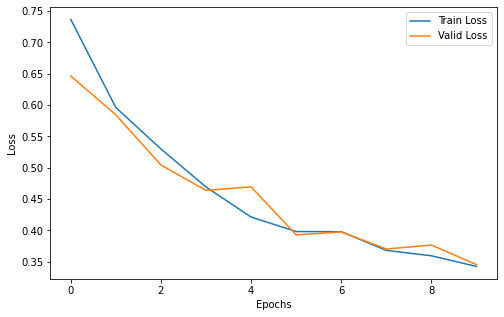

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(total_train_loss, label="Train Loss")
plt.plot(total_valid_loss, label="Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [33]:
test_dataset[0]

(tensor([[[0.8745, 0.8745, 0.8549,  ..., 0.7020, 0.6863, 0.6471],
          [0.8745, 0.8706, 0.8627,  ..., 0.7059, 0.6902, 0.6431],
          [0.8549, 0.8627, 0.8627,  ..., 0.7137, 0.7137, 0.6510],
          ...,
          [0.9333, 0.9333, 0.9333,  ..., 0.9451, 0.9451, 0.9059],
          [0.9255, 0.9412, 0.9333,  ..., 0.9333, 0.9373, 0.9020],
          [0.9451, 0.9451, 0.9373,  ..., 0.9451, 0.9451, 0.9176]],
 
         [[0.7765, 0.7765, 0.7647,  ..., 0.6196, 0.5961, 0.5569],
          [0.7765, 0.7725, 0.7725,  ..., 0.6235, 0.6000, 0.5529],
          [0.7647, 0.7725, 0.7725,  ..., 0.6314, 0.6235, 0.5608],
          ...,
          [0.9098, 0.9098, 0.9098,  ..., 0.9176, 0.9098, 0.8706],
          [0.8902, 0.9059, 0.9098,  ..., 0.9059, 0.9020, 0.8667],
          [0.9098, 0.9098, 0.9137,  ..., 0.9176, 0.9098, 0.8824]],
 
         [[0.5451, 0.5451, 0.5333,  ..., 0.4784, 0.4549, 0.4157],
          [0.5451, 0.5412, 0.5412,  ..., 0.4824, 0.4588, 0.4118],
          [0.5412, 0.5490, 0.5412,  ...,

In [34]:
# pick one image from the test set
img, _ = test_dataset[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [35]:
prediction

[{'boxes': tensor([[568.6565, 171.6333, 626.8091, 194.7637]], device='cuda:0'),
  'labels': tensor([2], device='cuda:0'),
  'scores': tensor([0.0606], device='cuda:0')}]

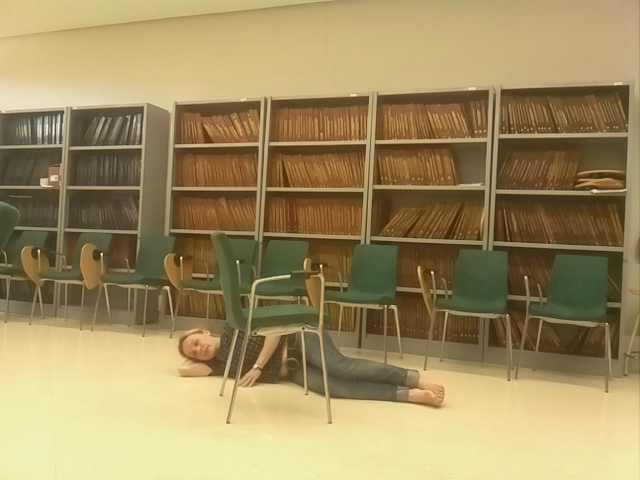

In [36]:
im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
im

In [37]:
from PIL import ImageDraw, ImageShow, ImageFont

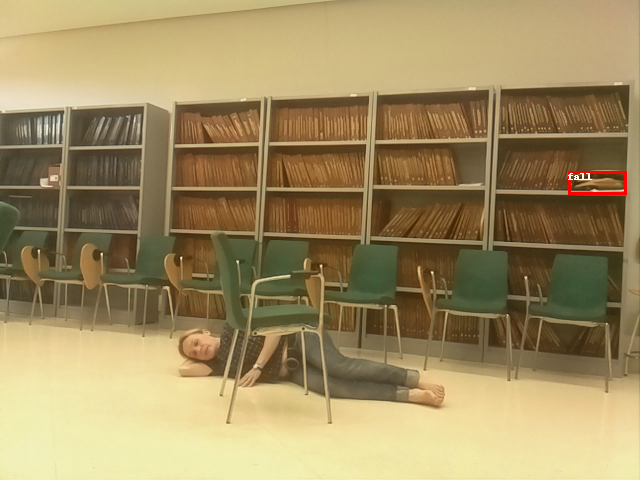

1

In [39]:
boxes = prediction[0]['boxes'].tolist()
labels = prediction[0]['labels'].tolist()
scores = prediction[0]['scores'].tolist()
l = len(scores)
# for b,l,s in boxes,labels,scores:
#     if s > 0.5:
#         if l == 1:
#             color = 'green'
#             text = 'no fall'
#         elif l == 2:
#             color = 'red'
#             text = 'fall'
#         x0,y0,x1,y1 = b
        
#         draw = ImageDraw.Draw(im)
#         draw.rectangle(((x0, y0),(x1,y1)), outline="green", width=3)

for i in range(l):
    if scores[i] > 0:
        if labels[i] == 1:
            color = 'green'
            text = 'no fall'
        elif labels[i] == 2:
            color = 'red'
            text = 'fall'
        x0,y0,x1,y1 = boxes[i]
        
        draw = ImageDraw.Draw(im)
        draw.rectangle(((x0, y0),(x1,y1)), outline=color, width=3)
        draw.text((x0, y0), text)
        
ImageShow.show(im)

In [54]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fallen_people_v1.pth')

In [ ]:
#QUESTA E' UNA PROVA